# Summary of processed LES data used for column model optimization

In this notebook we summarize some of the data generated by large eddy simulation that
we use to optimize column models.

The LES data has been processed by taking horizontal averages at particular times.
The processed data for each run is stored in a single `jld2` file along with information
about the surface flux conditions, bottom boundary conditions, and grid.

In [1]:
using Pkg; Pkg.activate("..")

using ColumnModelOptimizationProject, PyPlot, JLD2, Printf

┌ Info: Recompiling stale cache file /Users/gregorywagner/.julia/compiled/v1.0/ColumnModelOptimizationProject/HEzqG.ji for ColumnModelOptimizationProject [8137535c-6844-11e9-1caa-ffc4fab9c8ab]
└ @ Base loading.jl:1187


## A summary of four prototypical cases

We summarize data obtained for each of the four canonical cases:

1. Free convection
2. Wind-driven shear mixing with neutral buoyancy forcing
3. Wind-driven shear mixing with destabilizing buoyancy forcing
4. Wind-driven shear mixing with stabilizing buoyancy forcing

In [2]:
datadir = joinpath("..", "data", "idealized")

cases = ["free_convection", "shear_neutral", "shear_unstable", "shear_stable"]

dirs = Dict((c, joinpath(datadir, c)) for c in cases)

examples = Dict(
    "free_convection" => "wind_stress_N256_tau0_Q-75_dTdz0.01_k0.0001_dt0.25_days6_timeseries.jld2",
    "shear_neutral"   => "wind_stress_N256_tau0.1_Q0_dTdz0.001_k0.0001_dt0.25_days6_timeseries.jld2",
    "shear_unstable"  => "wind_stress_N256_tau0.1_Q-75_dTdz0.01_k0.0001_dt0.25_days6_timeseries.jld2",
    "shear_stable"    => "wind_stress_N256_tau0.04_Q10_dTdz0.01_k0.0001_dt0.25_days6_timeseries.jld2" )

examplepaths = Dict((c, joinpath(dirs[c], examples[c])) for c in cases)

Dict{String,String} with 4 entries:
  "shear_unstable"  => "../data/idealized/shear_unstable/wind_stress_N256_tau0.…
  "shear_stable"    => "../data/idealized/shear_stable/wind_stress_N256_tau0.04…
  "free_convection" => "../data/idealized/free_convection/wind_stress_N256_tau0…
  "shear_neutral"   => "../data/idealized/shear_neutral/wind_stress_N256_tau0.1…

# File structure of the processed data

The processed data files are `jld2` files with the groups:

* `grid`
* `boundary_conditions`
* `initial_condition`
* `timestepping`
* `constants`
* `timeseries`

The first five groups give information about the model setup. The last group, `timeseries`, 
stores the horizontally-averaged, one-dimensional large eddy simulation data for the four
fields \$ U \$, \$ V \$, \$ T \$, \$ S \$.

Below we visualize the format of the dataset.

In [3]:
file = jldopen(examplepaths["shear_unstable"], "r")
@show file
close(file)

file = JLDFile /Users/gregorywagner/Projects/ColumnModelOptimizationProject.jl/data/idealized/shear_unstable/wind_stress_N256_tau0.1_Q-75_dTdz0.01_k0.0001_dt0.25_days6_timeseries.jld2 (read-only)
 ├─📂 grid
 │  ├─🔢 N
 │  └─🔢 L
 ├─📂 boundary_conditions
 │  ├─🔢 Fb
 │  └─🔢 Fu
 ├─📂 initial_condition
 │  └─🔢 Bz
 ├─📂 timestepping
 │  ├─🔢 dt
 │  └─🔢 tfinal
 ├─📂 constants
 │  ├─🔢 ρ₀
 │  ├─🔢 cP
 │  ├─🔢 g
 │  ├─🔢 α
 │  ├─🔢 f
 │  └─🔢 κ
 └─📂 timeseries
    ├─📂 t
    │  ├─🔢 0
    │  ├─🔢 64800
    │  ├─🔢 129600
    │  ├─🔢 194400
    │  ├─🔢 259200
    │  ├─🔢 324000
    │  ├─🔢 388800
    │  ├─🔢 453600
    │  ├─🔢 518400
    │  ├─🔢 583200
    │  ├─🔢 648000
    │  ├─🔢 712800
    │  ├─🔢 777600
    │  ├─🔢 842400
    │  ├─🔢 907200
    │  ├─🔢 972000
    │  ├─🔢 1036800
    │  ├─🔢 1101600
    │  ├─🔢 1166400
    │  ├─🔢 1231200
    │  ├─🔢 1296000
    │  ├─🔢 1360800
    │  ├─🔢 1425600
    │  ├─🔢 1490400
    │  ├─🔢 1555200
    │  ├─🔢 1620000
    │  ├─🔢 1684800
    │  ├─🔢 1749600
    │  ├─🔢 1814400
    │  ├─🔢 187920

# Comparison plots

We use the `ColumnModelOptimizationProject` function `summarize_data`
to plot one-dimensional profiles of temperature and velocity
at four different times.

The time-points of comparison are specified by a vector of data indices `idata`.

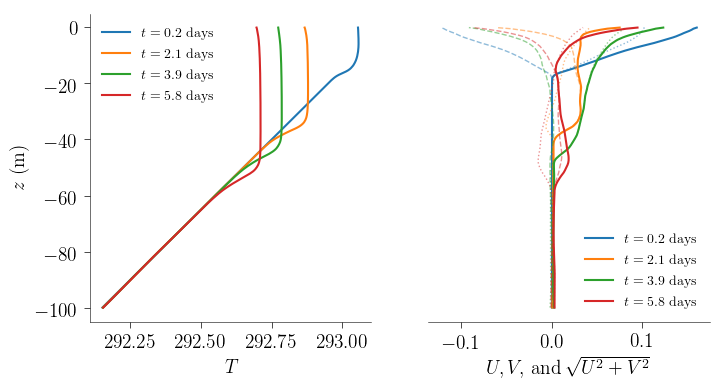

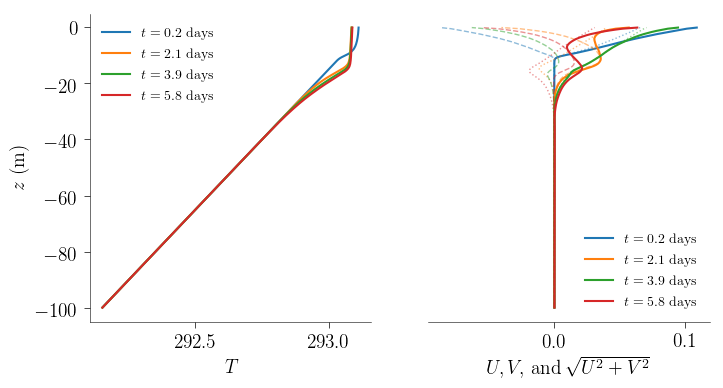

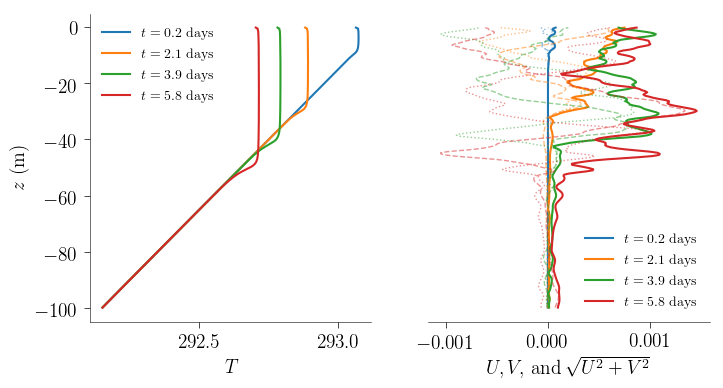

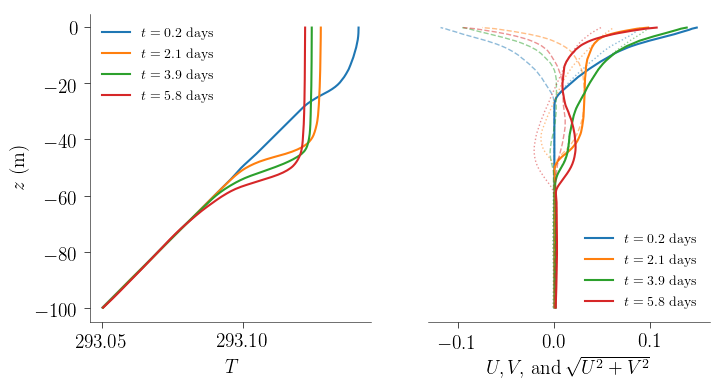

In [4]:
idata = [2, 12, 22, 32]

figs = []
axs = []
titles = []

for (case, filepath) in examplepaths
    fig, ax = summarize_data(filepath, idata=idata)
end

for (i, fig) in enumerate(figs)
    fig.suptitle(replace(titles[i], "_" => " "))
    savefig(titles[i] * "_example.png", dpi=480)
end

In [5]:
using OceanTurb, ColumnModelOptimizationProject.KPPOptimization

function compare_with_data(datapath; idata₀=2, idata=[12, 22, 32], parameters=KPP.Parameters(), Δt=10*minute)
    
    model = simple_flux_model(datapath)
    model.parameters = parameters

    alltimes = times(datapath)
    compare_times = [alltimes[i] for i in idata]
    initial_time = alltimes[idata₀]

    N, L = getgridparams(datapath)
    grid = UniformGrid(N, L)

    fields = [:U, :V, :T, :S]
    datafields = Dict((fld, CellField(grid)) for fld in fields)

    for fld in fields
        OceanTurb.set!(datafields[fld], getdata(fld, datapath, idata₀))
        OceanTurb.set!(getproperty(model.solution, fld), datafields[fld])
    end

    solution_dict(model) = Dict((fld, deepcopy(getproperty(model.solution, fld))) for fld in fields)

    # Store results in a dict.
    modeloutput = Dict(idata₀ => solution_dict(model))
    data = Dict(idata₀ => deepcopy(datafields))
    t = Dict(idata₀ => initial_time)

    for (i, ti) in enumerate(compare_times)
        id = idata[i]
        run_until!(model, Δt, ti)

        t[id] = ti
        modeloutput[id] = solution_dict(model)

        # Load and store data at the points of comparison.
        [OceanTurb.set!(datafields[fld], getdata(fld, datapath, id)) for fld in fields]
        data[id] = deepcopy(datafields)
    end

    return modeloutput, data, t
end


compare_with_data (generic function with 1 method)

In [6]:
output, data, t = compare_with_data(examplepaths["shear_unstable"])

(Dict(32=>Dict(:U=>CellField{Array{Float64,1},UniformGrid{Float64,StepRangeLen{Float64,TwicePrecision{Float64},TwicePrecision{Float64}}},Float64}([47.3682, 47.3678, 47.3676, 47.3675, 47.3675, 47.3675, 47.3676, 47.3677, 47.3678, 47.3679  …  47.3374, 47.3348, 47.3319, 47.3283, 47.324, 47.3185, 47.3109, 47.2993, 47.2755, -0.257542], UniformGrid{Float64,StepRangeLen{Float64,TwicePrecision{Float64},TwicePrecision{Float64}}}(256, 100.0, 0.390625, 0.390625, -99.8046875:0.390625:-0.1953125, -100.0:0.390625:0.0)),:T=>CellField{Array{Float64,1},UniformGrid{Float64,StepRangeLen{Float64,TwicePrecision{Float64},TwicePrecision{Float64}}},Float64}([292.329, 292.328, 292.327, 292.326, 292.326, 292.325, 292.325, 292.324, 292.324, 292.324  …  292.307, 292.307, 292.306, 292.306, 292.305, 292.304, 292.303, 292.301, 292.297, 291.736], UniformGrid{Float64,StepRangeLen{Float64,TwicePrecision{Float64},TwicePrecision{Float64}}}(256, 100.0, 0.390625, 0.390625, -99.8046875:0.390625:-0.1953125, -100.0:0.390625:0.